In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
import os
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
env = gym.make('MountainCar-v0', render_mode="human")

In [3]:
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

Action space: Discrete(3)
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


In [42]:
starting_state, _ = env.reset() 

print(f"Starting state: {starting_state}")

Starting state: [-0.54881835  0.        ]


In [89]:
class DynaAgent():
    def __init__(self,env,size_bin_x=0.025,size_bin_y=0.005,epsilon_start=0.9,epsilon_end=0.05,alpha=0.1,gamma=0.99,k=5):
        self.env = env
        
        self.n_bins_x = int((env.observation_space.high[0]-env.observation_space.low[0])/size_bin_x)
        # print(f"Number of bins in x: {self.n_bins_x}")
        # print((env.observation_space.high[0]-env.observation_space.low[0])/size_bin_x)
        assert (env.observation_space.high[0]-env.observation_space.low[0])/size_bin_x-self.n_bins_x<1e-5 , "size_bin_x is not a divisor of the range of the x axis"
        self.n_bins_y= int((env.observation_space.high[1]-env.observation_space.low[1])/size_bin_y)
        assert (env.observation_space.high[1]-env.observation_space.low[1])/size_bin_y-self.n_bins_y<1e-5 , "size_bin_y is not a divisor of the range of the y axis"
        self.disc_step=np.array([size_bin_x,size_bin_y])
        self.x_bins = np.linspace(env.observation_space.low[0],env.observation_space.high[0],self.n_bins_x+1)
        self.y_bins= np.linspace(env.observation_space.low[1],env.observation_space.high[1],self.n_bins_y+1)
        
    
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.alpha = alpha
        self.gamma = gamma
        self.k=k
        self.n_states= (self.n_bins_x+1)*(self.n_bins_y+1)
        self.counts_total=np.zeros((self.n_states,3))
        self.counts_transition=np.zeros((self.n_states,3,self.n_states))
        self.P=np.ones((self.n_states,3,self.n_states))*1/self.n_states
        self.R=np.zeros((self.n_states,3))
        self.Q=np.zeros((self.n_states,3))
        self.model = {}
        self.last_reward_step=0
        self.timesteps_per_reward=[]
        
        self.state_action_pairs_encontered = []
        
        self.state=self.discretize_position(self.env.reset()[0])
        self.nb_training_episodes=0
        self.q_value_updates=[]
        self.stored_max_q_every_250_episodes=[]
        self.stored_trajectories_every_250_episodes=[]
    def discretize_position(self,position):
        # if np.digitize(position[0],self.x_bins)*np.digitize(position[1],self.y_bins)+np.digitize(position[1],self.y_bins)>=2016:
        #     print(np.digitize(position[0],self.x_bins)*np.digitize(position[1],self.y_bins)+np.digitize(position[1],self.y_bins))
        #     raise ValueError(f"position: {position} is out of bounds")
        return np.digitize(position[0],self.x_bins)+np.digitize(position[1],self.y_bins)*(self.n_bins_x+1)
    
    def update_P(self,state,action,next_state):
        self.counts_total[state,action]+=1
        self.counts_transition[state,action,next_state]+=1
        self.P[state,action,next_state]=self.P[state,action,next_state]+self.counts_transition[state,action,next_state]/(1+self.counts_total[state,action])
        self.P[state,action]/=np.sum(self.P[state,action])
        pass
    
    def update_R(self,state,action,reward):
        self.R[state,action] = (self.R[state,action]*(self.counts_total[state,action]-1)+reward)/self.counts_total[state,action]
        pass
    
    def update_Q(self,state,action):
        new_q=self.R[state,action]+self.gamma*np.sum(self.P[state,action]*np.max(self.Q,axis=1))
        self.q_value_updates.append(new_q-self.Q[state][action])
        self.Q[state][action]=new_q
        pass
        
    def update_step(self,epsilon):
        state=self.state
        if np.random.rand()<epsilon:
            action = np.random.choice([0,1,2])
        else:
            action = np.argmax(self.Q[state])
        self.state_action_pairs_encontered.append((state,action))
            
        next_state, reward, done, truncated ,_= self.env.step(action)
        #print(next_state)
        next_state=self.discretize_position(next_state)
        #self.Q[state][action] += self.alpha*(reward+self.gamma*np.max(self.Q[next_state])-self.Q[state][action])# TO DOOOOOOOOOOOOOOto be changeddddddd
        self.update_P(state,action,next_state)
        self.update_R(state,action,reward)
        #self.Q[state][action] = self.Q[state][action]+self.alpha*(reward+self.gamma*np.max(self.Q[next_state])-self.Q[state][action])
        self.update_Q(state,action)
        
        self.state=next_state
        
        for planning_step in range(self.k):
            state,action = self.state_action_pairs_encontered[np.random.choice(len(self.state_action_pairs_encontered))]
            reward = self.R[state,action]
            self.Q[state][action] =reward+self.gamma*np.sum(self.P[state,action]*np.max(self.Q,axis=1))#TO DOOOOOOOOOOOOOOOOOOOOOOOto be chnageddddddddddddddd
        
        return done,truncated
    
    def training(self,n_steps,reset=True,render=False):
        if render:
            self.env=gym.make('MountainCar-v0', render_mode="human")
        else:
            self.env=gym.make('MountainCar-v0')
        print("Training...")
        if reset:
            self.state=self.discretize_position(self.env.reset()[0])
        else:
            pass
        epsilon = self.epsilon_start
        
        
        
        
        for i in tqdm(range(n_steps)):#number or episodes
            if self.nb_training_episodes%250==0:#store max q values and trajectories every 250 episodes
                self.stored_max_q_every_250_episodes.append(np.max(self.Q,axis=-1))
                self.stored_trajectories_every_250_episodes.append([self.state])
                store_traj=True
            done=False
            truncated=False
            while not(done|truncated):
                done,truncated=self.update_step(epsilon)
                if store_traj:
                    self.stored_trajectories_every_250_episodes[-1].append(self.state)
                    
                if done:
                    print(f"Episode finished after {i-self.last_reward_step} timesteps")
                    self.timesteps_per_reward.append((i,i-self.last_reward_step))
                    self.last_reward_step=i
                    self.state=self.discretize_position(self.env.reset()[0])
                elif truncated:
                    self.state=self.discretize_position(self.env.reset()[0])
                    
                    
            self.nb_training_episodes+=1                
                
                #epsilon exponential decay:
            epsilon = self.epsilon_end+(self.epsilon_start-self.epsilon_end)*np.exp(-i/1000)
           
            
        pass
    
    
    def inference(self,max_steps,render=True):
        if render:
            self.env=gym.make('MountainCar-v0', render_mode="human")
        else:
            self.env=gym.make('MountainCar-v0')
        state=self.discretize_position(self.env.reset()[0])
        tot_reward=0
        #self.env.render()
        for i in range(max_steps):
            action = np.argmax(self.Q[state])
            next_state, reward, done, _ ,_= self.env.step(action)
            next_state=self.discretize_position(next_state)
            tot_reward+=reward
            state=next_state
            if done:
                if render:
                    print(f"Episode finished after {i} timesteps")
                break
        if render:
            print(f'total reward: {tot_reward}')
        return tot_reward
    
    def save_agent(self,path):
        if not os.path.exists("agents_saved/"+path+"/"):
            os.makedirs("agents_saved/"+path+"/")
        path="agents_saved/"+path+"/"
        np.save(path+"_P.npy",self.P)
        np.save(path+"_Q.npy",self.Q)
        np.save(path+"_R.npy",self.R)
        #store it as pickle
        pickle.dump(self.state_action_pairs_encontered, open(path+"_state_action_pairs_encontered.pkl", 'wb'))
        np.save(path+"_counts_total.npy",self.counts_total)
        np.save(path+"_counts_transition.npy",self.counts_transition)
        pass
    
    def load_agent(self,path):
        path="agents_saved/"+path+"/"
        self.P=np.load(path+"_P.npy")
        self.Q=np.load(path+"_Q.npy")
        self.R=np.load(path+"_R.npy")
        #self.state_action_pairs_encontered=np.load(path+"_state_action_pairs_encontered.npy")
        with open(path+"_state_action_pairs_encontered.pkl", 'rb') as f:
            self.state_action_pairs_encontered = pickle.load(f)
        self.counts_total=np.load(path+"_counts_total.npy")
        self.counts_transition=np.load(path+"_counts_transition.npy")
        pass

# 1. Classic Dyna agent


In [90]:
env = gym.make('MountainCar-v0')
dyna_agent=DynaAgent(env)


In [ ]:
dyna_agent.training(3000,reset=True)

In [92]:
dyna_agent.save_agent("dyna_agent0905")

In [58]:
def plot_nb_episodes_per_reward(agent,filename):
    nb_episodes_per_reward=[duration[1] for duration in agent.timesteps_per_reward]
    plt.scatter(range(len(nb_episodes_per_reward)),nb_episodes_per_reward,s=2,alpha=0.5)
    plt.yscale("log")
    plt.xlabel("Number of times the agent has reached the goal")
    plt.ylabel("Number of episodes between two rewards")
    plt.savefig(f"plots/dyna/{filename}.png")
    plt.show()
    

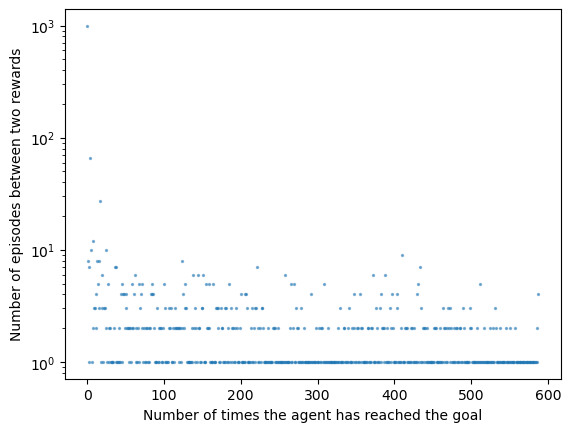

In [94]:
plot_nb_episodes_per_reward(dyna_agent,"dyna_agent0905")

### testing perf

In [99]:
dyna_agent.inference(2000,render=False)

-166.0

In [86]:
def inference_test(agent,n_tests):
    nb_done_under_200_steps=0
    for i in tqdm(range(n_tests)):
        reward=agent.inference(2000,render=False)
        if reward>=-200:
            nb_done_under_200_steps+=1
    print(f"Proportion of successful episodes: {nb_done_under_200_steps/n_tests*100} %")
    return nb_done_under_200_steps/n_tests

In [100]:
inference_test(dyna_agent,100)

100%|██████████| 100/100 [00:01<00:00, 51.45it/s]

Proportion of successful episodes: 100.0 %


1.0

### Q Update steps

In [144]:
def show_q_updates(agent):
    y_vals=agent.q_value_updates[::10]
    x_vals=range(len(y_vals))
    plt.scatter(x_vals,y_vals,s=3,alpha=0.2)
    plt.hlines(1,1,len(y_vals),linestyles='dashed',colors='r')
    plt.yscale("log")
    plt.xlabel("Step number (*10)")
    plt.ylabel("Q value update")
    plt.title("Q value updates every 10 steps")
    plt.show()

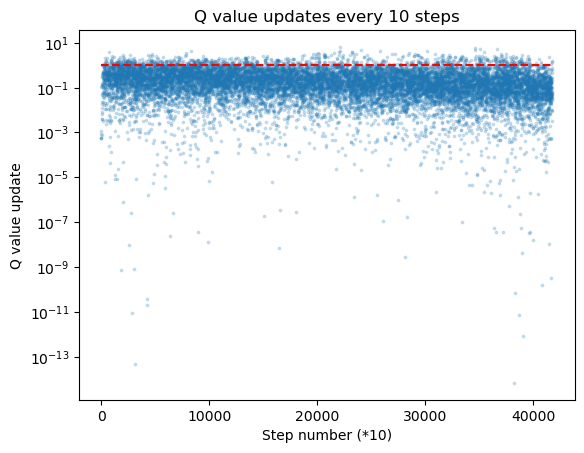

In [145]:
show_q_updates(dyna_agent)

### Max Q plot

In [103]:

def show_max_Q(agent):
    """Plot max Q value for each state
    Args:
        agent: An agent object with Q-values and state bins attributes
    """
    plt.figure(figsize=(10, 10))
    
    # Calculate max Q value per state and set zeros to NaN
    max_Q = agent.Q.max(axis=-1).copy()
    #max_Q[2000]=100
    max_Q=max_Q.reshape((agent.n_bins_y+1), (agent.n_bins_x+1))
    max_Q[max_Q == 0] = np.nan  # Replace zeros with NaN
    
    # Use imshow to plot, NaN values will not be displayed
    plt.imshow(max_Q, origin='lower', aspect='auto', cmap='viridis',extent=[-1.2, 0.6, -0.07, 0.07])  # Added cmap for better color handling
    plt.colorbar()
    plt.title(f"Max Q values (after {agent.nb_training_episodes} episodes)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.savefig("plots/dyna/max_q")
    plt.show()

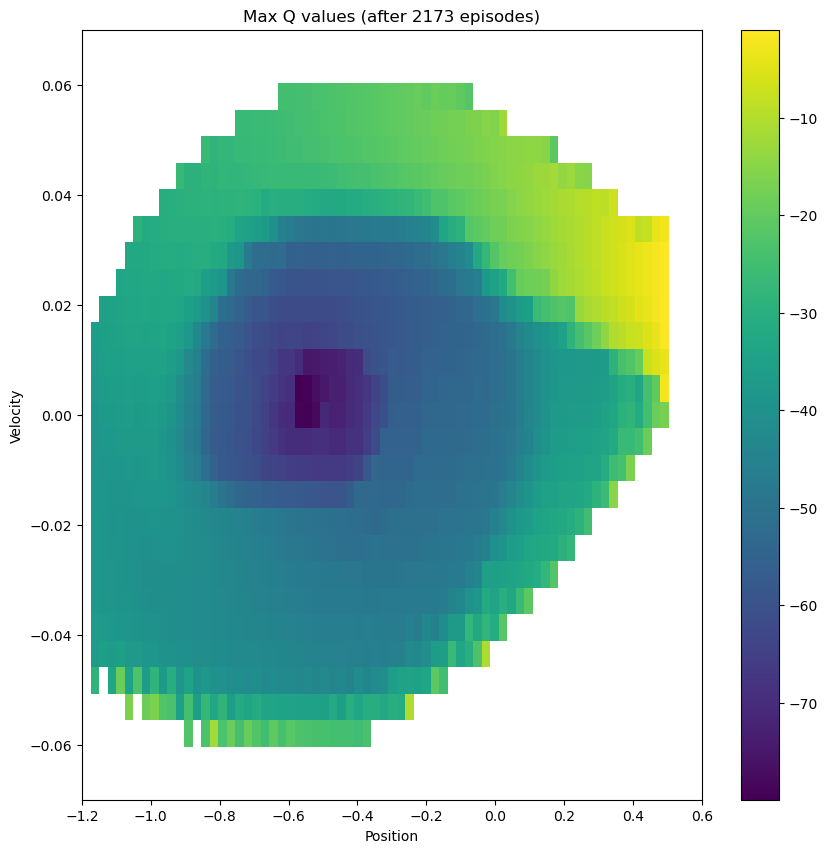

In [104]:
show_max_Q(dyna_agent)

# 2. Small size vs large size bins

### Small bins

In [52]:
dyna_small=DynaAgent(env,size_bin_x=0.0125,size_bin_y=0.0025)

In [ ]:
dyna_small.training(3000,reset=True,render=False)

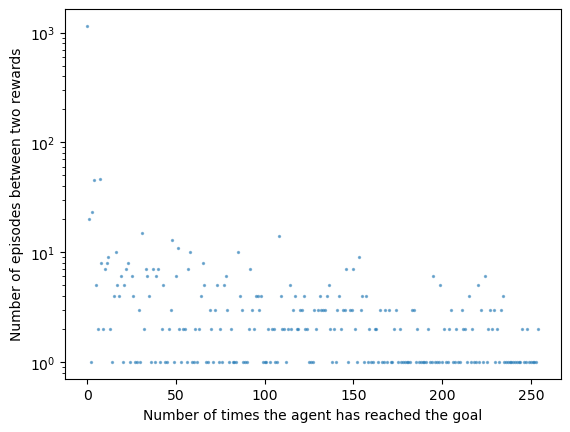

In [59]:
plot_nb_episodes_per_reward(dyna_small,filename="dyna_small_training")

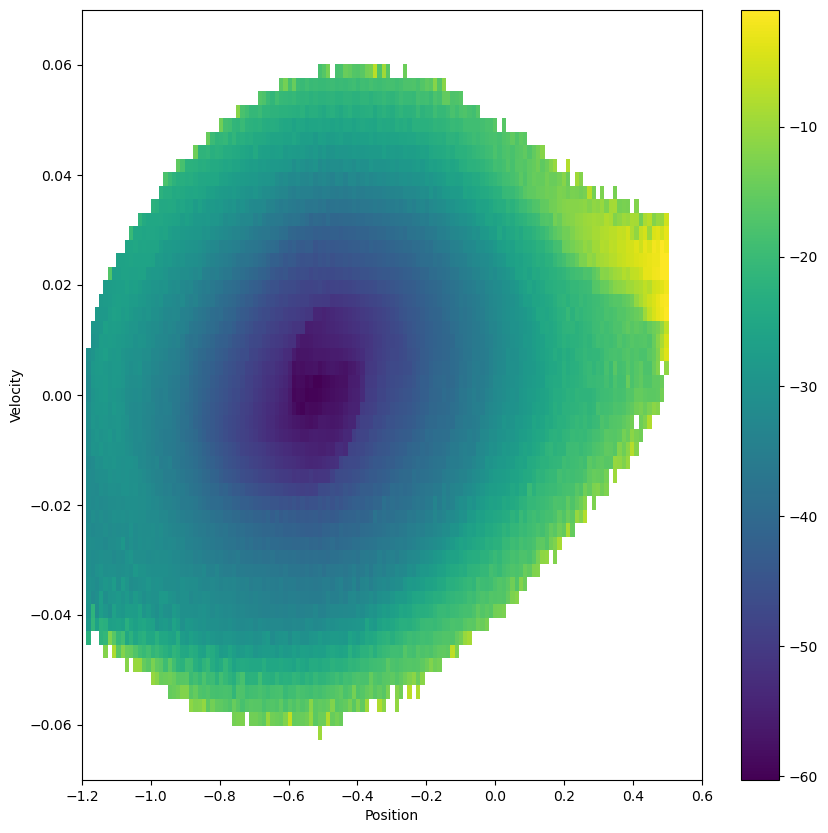

In [67]:
show_max_Q(dyna_small)

In [71]:
dyna_small.inference(2000,render=True)

Episode finished after 163 timesteps
total reward: -164.0


-164.0

In [84]:
inference_test(dyna_small,1000)

100%|██████████| 1000/1000 [00:24<00:00, 41.14it/s]

Proportion of successful episodes: 0.863


0.863

### Big bins

In [54]:
dyna_big=DynaAgent(env,size_bin_x=0.05,size_bin_y=0.01)

In [ ]:
dyna_big.training(3000,reset=True,render=False)

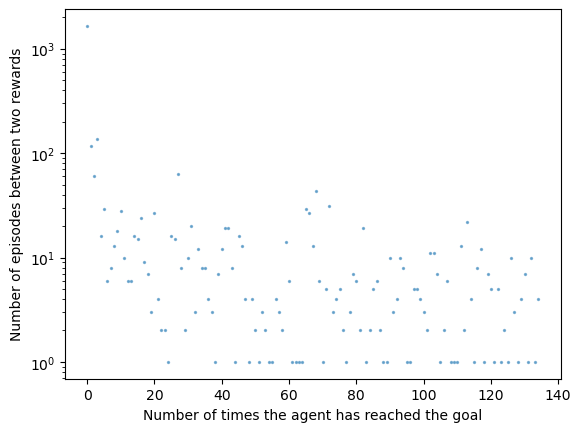

In [60]:
plot_nb_episodes_per_reward(dyna_big,filename="dyna_big_training")

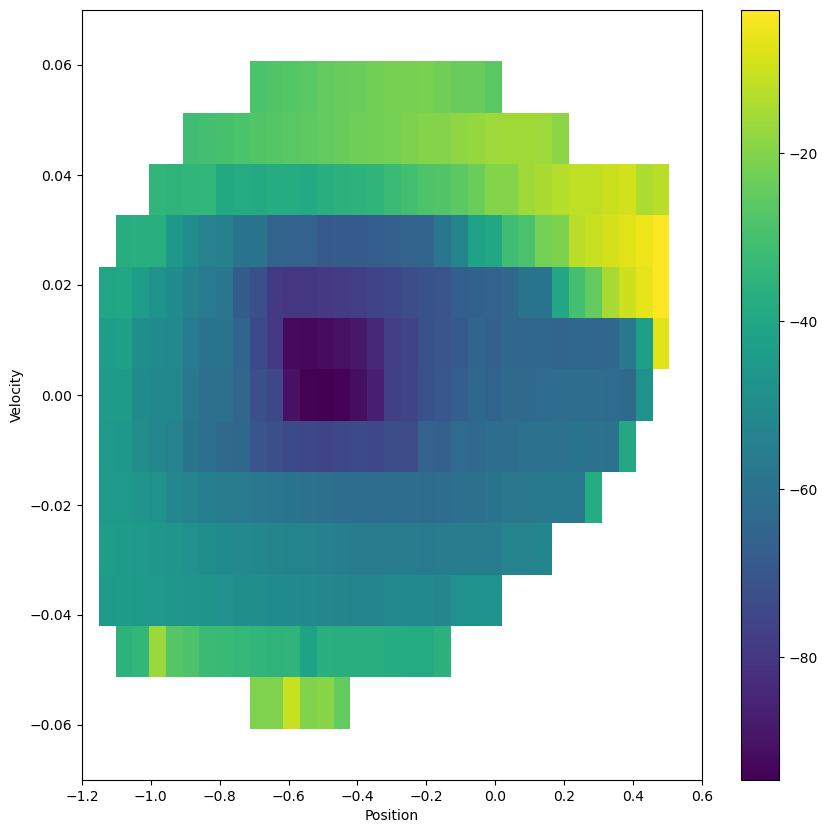

In [68]:
show_max_Q(dyna_big)

In [76]:
dyna_big.inference(2000,render=True)

Episode finished after 130 timesteps
total reward: -131.0


-131.0

In [85]:
inference_test(dyna_big,1000)

100%|██████████| 1000/1000 [00:18<00:00, 53.85it/s]


Proportion of successful episodes: 0.61


0.61

 ### Appendix: Try to find a good heuristic

In [ ]:
x_range=np.linspace(env.observation_space.low[0],env.observation_space.high[0],dyna_agent.n_bins_x+1)
y_range=np.linspace(env.observation_space.low[1],env.observation_space.high[1],dyna_agent.n_bins_y+1)
def q_value(x,y):
    return -1*np.exp(-4*(x+0.5)**2-600*(y)**2)
X,Y=np.meshgrid(x_range,y_range)
Z=q_value(X,Y)
plt.figure(figsize=(10, 8))
plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')  # Use a colormap that fits your data range, 'viridis' is just an example
plt.colorbar()  # Show color scale
plt.title("Max Q value (after 30,000 episodes)")
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.show()